In [1]:
%matplotlib inline
import sys 
sys.path.append('..')
import matplotlib
import mglearn
import os

from preamble import *
plt.rcParams['image.cmap'] = "gray"

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

from matplotlib.pyplot import rc
rc('font',family='New Gulim') #plot 한글폰트 적용

cancer = load_breast_cancer()

In [3]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# 0~255 사이의 흑백 이미지의 픽셀 값을 0~1 사이로 스케일 조정합니다.
# (옮긴이) MinMaxScaler를 적용하는 것과 거의 동일합니다.
X_people = X_people / 255.

from sklearn.neighbors import KNeighborsClassifier
# 데이터를 훈련 세트와 테스트 세트로 나눕니다
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)

### 3.4.2 NMF (음수 미포함 행렬 분해)

#### 인공 데이터에 NMF 적용하기

In [4]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

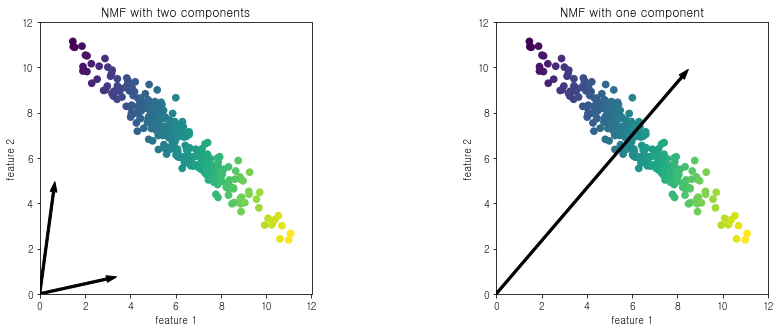

In [5]:
mglearn.plots.plot_nmf_illustration()

### 얼굴 이미지에 NMF 적용하기

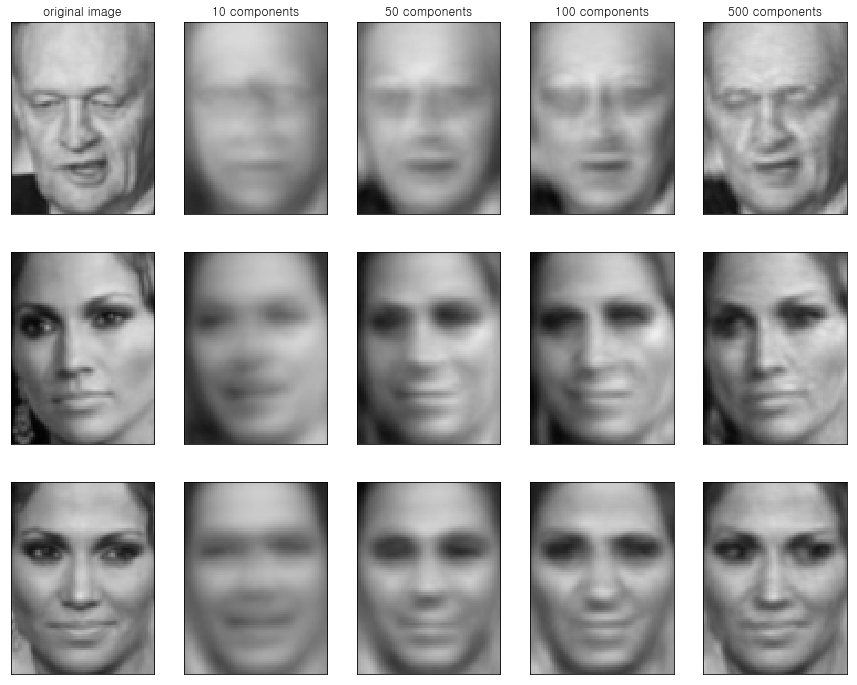

In [6]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("성분 {}".format(i))mglearn.plots.plot_nmf_faces(X_train, X_test, image_shape)

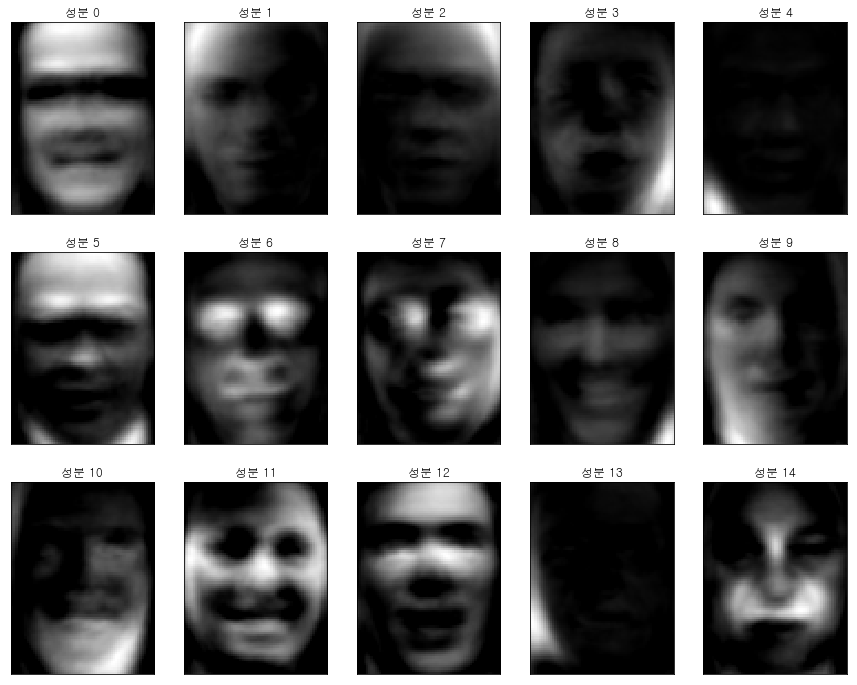

In [7]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("성분 {}".format(i))

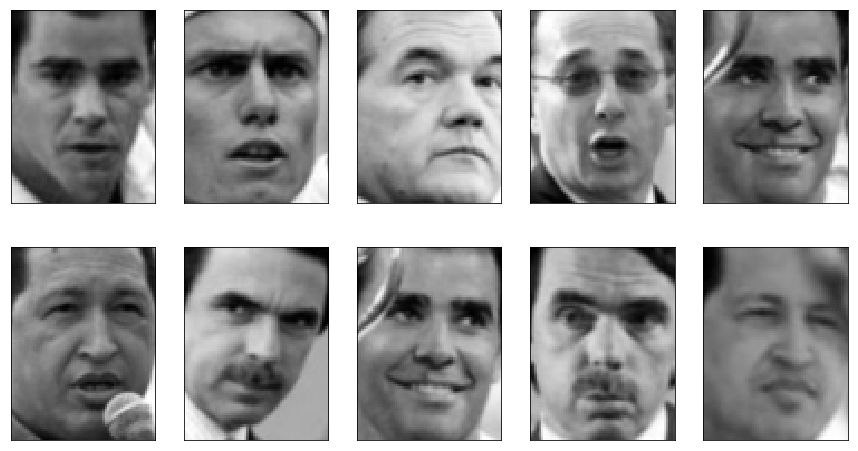

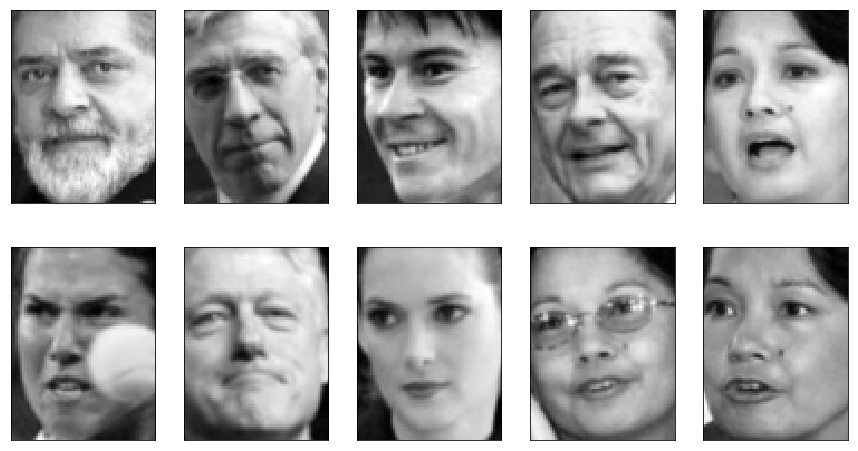

In [8]:
compn = 3
# 4번째 성분으로 정렬하여 처음 10개 이미지를 출력합니다
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))
    
compn = 7
# 8번째 성분으로 정렬하여 처음 10개 이미지를 출력합니다
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

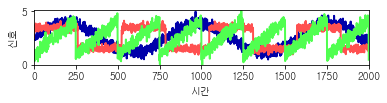

In [9]:
S = mglearn.datasets.make_signals()
plt.figure(figsize=(6, 1))
plt.plot(S, '-')
plt.xlabel("시간")
plt.ylabel("신호")
plt.margins(0)

In [10]:
# 원본 데이터를 사용해 100개의 측정 데이터를 만듭니다
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print("측정 데이터 형태: {}".format(X.shape))

측정 데이터 형태: (2000, 100)


In [11]:
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print("복원한 신호 데이터 형태: {}".format(S_.shape))

복원한 신호 데이터 형태: (2000, 3)


In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
H = pca.fit_transform(X)

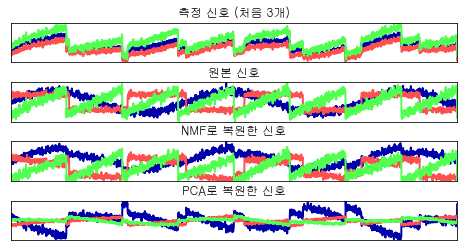

In [14]:
models = [X, S, S_, H]
names = ['측정 신호 (처음 3개)',
         '원본 신호',
         'NMF로 복원한 신호', 
         'PCA로 복원한 신호']

fig, axes = plt.subplots(4, figsize=(8, 4), gridspec_kw={'hspace': .5},
                         subplot_kw={'xticks': (), 'yticks': ()})

for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')
    ax.margins(0)

### t-SNE를 이용한 매니폴드 학습

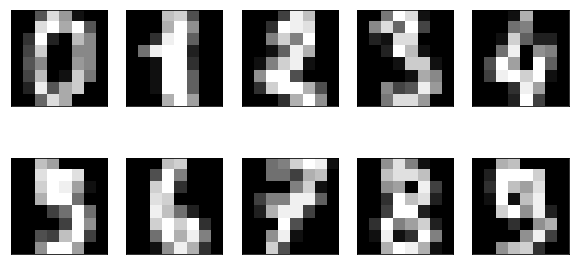

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                         subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)